In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import os

import torch
from torch.utils.data import random_split
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.cuda.is_available()

True

In [3]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [4]:
device = get_default_device()
device

device(type='cuda')

In [5]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [6]:
#reading datasets
base_path = '/home/sggs/skin_cancer/'
test_path = base_path + 'test/'

train_path = base_path + 'train/'

Import dataset 

In [7]:
from torchvision import datasets, transforms

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [8]:
train_dataset = datasets.ImageFolder(root=train_path, transform=data_transform)

# X_train = torch.stack([image for image, _ in enumerate(train_dataset)])
# y_train = torch.stack([labels for labels, _ in train_dataset])

y_train = []
X_train = torch.Tensor(2637, 3, 224, 224)

for i, (image, label) in enumerate(train_dataset):
  X_train[i, :, :, :] = image
  y_train.append(label)
y_train = torch.Tensor(y_train)

In [9]:
batch_size = 32
num_workers = 2

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [11]:
train_loader

In [12]:
# Load benign images
test_dataset = datasets.ImageFolder(root=test_path, transform=data_transform)

y_test = []
X_test = torch.Tensor(660, 3, 224, 224)

for i, (image, label) in enumerate(test_dataset):
  X_test[i, :, :, :] = image
  y_test.append(label)
y_test = torch.Tensor(y_test)

In [13]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [14]:
def show_example(img, label, dataset):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

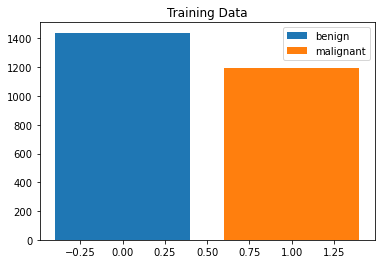

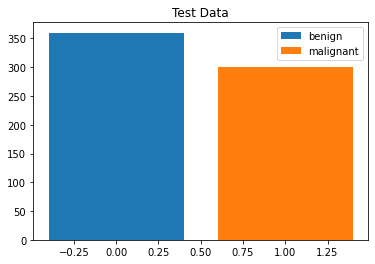

In [15]:
plt.bar(0, y_train[np.where(y_train == 0)].shape[0], label = 'benign')
plt.bar(1, y_train[np.where(y_train == 1)].shape[0], label = 'malignant')
plt.legend()
plt.title("Training Data")
plt.show()

plt.bar(0, y_test[np.where(y_test == 0)].shape[0], label = 'benign')
plt.bar(1, y_test[np.where(y_test == 1)].shape[0], label = 'malignant')
plt.legend()
plt.title("Test Data")
plt.show()

Label:  benign (0)


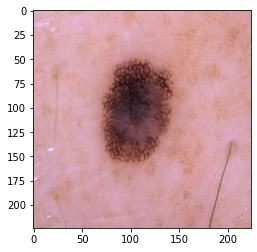

In [16]:
show_example(*train_dataset[0], train_dataset)

Label:  malignant (1)


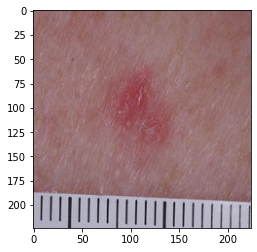

In [17]:
show_example(*test_dataset[605], test_dataset)

In [18]:
# for images, _ in train_loader:
#     images = images.cpu()
    
#     print('images.shape:', images.shape)
#     plt.figure(figsize=(224,224))
#     plt.axis('off')
#     plt.imshow(make_grid(images, nrow=4).permute((1, 2, 0)))
#     break

<h2>Model - Logistic Regression</h2>

In [19]:
import torch.nn as nn

In [20]:
img, label = train_dataset[0]
print(img.shape, label)

torch.Size([3, 224, 224]) 0


In [21]:
X_train = X_train/255.
X_test = X_test/255.
X_train.shape, X_test.shape

(torch.Size([2637, 3, 224, 224]), torch.Size([660, 3, 224, 224]))

In [22]:
import torch.nn.functional as F

class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Flatten the input tensor
        x = x.view(x.size(0), -1)
        
        out = self.linear(x)
        out = self.sigmoid(out)
        return out
    
    def training_step(self, batch):
        inputs, labels = batch
        labels = labels.view(-1, 1)  # Reshape labels to match the shape of outputs

        outputs = self(inputs)
        labels = labels.float()  # Convert labels to Float
        loss = F.binary_cross_entropy(outputs, labels)
        return loss
    



In [23]:
input_size = 224 * 224 * 3 # For 224x224 RGB images
model = LogisticRegression(input_size)

# Binary Cross-Entropy Loss
criterion = nn.BCELoss()
log_criterion = nn.BCEWithLogitsLoss()


# Stochastic Gradient Descent Optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [24]:
epochs = 100

In [25]:
for images, labels in train_loader:
    flattened_images = images.view(images.size(0), -1)
    images = to_device(flattened_images, device)
    print(flattened_images.shape)
    print(images.device)
    break

torch.Size([32, 150528])
cuda:0


In [26]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [27]:
train_loader = DeviceDataLoader(train_loader, device)

In [28]:
for xb, yb in test_loader:
    print()
    print('xb.device:', xb.device)
    print('yb:', yb)
    break


xb.device: cpu
yb: tensor([0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
        0, 0, 0, 0, 1, 0, 0, 1])


In [43]:
def evaluate(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    device = next(model.parameters()).device  # Get the device of the model
    with torch.no_grad():  # Disable gradient calculation during evaluation
        for inputs, labels in test_loader:
            inputs = inputs.view(inputs.size(0), -1)
            inputs = inputs.to(device)  # Move inputs to the same device as the model
            labels = labels.to(device)  # Move labels to the same device as the model
            outputs = model(inputs)  # Forward pass
            predictions = torch.round(outputs)  # Convert probabilities to binary predictions
            correct += (predictions == labels).sum().item()  
            total += labels.size(0)  # Count total number of samples
    accuracy = correct / total
    return accuracy


def fit(epochs, lr, model, train_loader, test_loader, opt_func=torch.optim.SGD):
    reg_history = []
    loggy_accuracy = 0.00
    for epoch in range(epochs):
        for images, labels in train_loader:
            # Flatten images into shape (batch_size, input_size)
            images = images.view(images.size(0), -1)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(outputs, dim=1)            
            accuracy = torch.tensor(torch.sum(preds == labels).item() / len(preds))

            # Print progress
        if (epoch+1) % 1 == 0:
          reg_history.append(loss.item())
          print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, loss.item()))
          print("Accuracy: ", accuracy)
        
          if accuracy > loggy_accuracy:
              loggy_accuracy = accuracy
              torch.save(model.state_dict(), 'logistic_regression.pth')
                
    print("Best Accuracy: ", loggy_accuracy)               
    return reg_history

In [38]:
#Model (on GPU)
model = LogisticRegression(input_size)
to_device(model, device)

LogisticRegression(
  (linear): Linear(in_features=150528, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [39]:
history = [evaluate(model, test_loader)]
history

[17.28181818181818]

In [44]:
history += fit(10, 0.001, model, train_loader, test_loader)

Epoch [1/10], Loss: 0.7447
Accuracy:  tensor(0.3077)
Epoch [2/10], Loss: 0.7173
Accuracy:  tensor(0.3846)
Epoch [3/10], Loss: 0.6484
Accuracy:  tensor(0.6154)
Epoch [4/10], Loss: 0.6304
Accuracy:  tensor(0.6923)
Epoch [5/10], Loss: 0.6766
Accuracy:  tensor(0.5385)
Epoch [6/10], Loss: 0.7264
Accuracy:  tensor(0.4615)
Epoch [7/10], Loss: 0.6319
Accuracy:  tensor(0.6923)
Epoch [8/10], Loss: 0.6112
Accuracy:  tensor(0.7692)
Epoch [9/10], Loss: 0.7478
Accuracy:  tensor(0.2308)
Epoch [10/10], Loss: 0.6656
Accuracy:  tensor(0.5385)
Best Accuracy:  tensor(0.7692)


In [41]:
history

[17.28181818181818,
 0.6523505449295044,
 0.6702322363853455,
 0.7040210366249084,
 0.7029187679290771,
 0.6792935729026794,
 0.6690754294395447,
 0.6883013844490051,
 0.7016727924346924,
 0.6907479763031006,
 0.6871256232261658]

<h2 style="color:red">Saving the model to device</h2>

In [55]:
model1 = LogisticRegression(input_size)
to_device(model1, device)
model1.load_state_dict(torch.load('logistic_regression.pth'))

<All keys matched successfully>

In [56]:
def evaluate(model, loader):
    model.eval() 
    correct = 0
    total = 0
    device = next(model.parameters()).device  # Get the device of the model
    with torch.no_grad():  # Disable gradient calculation during evaluation
        for inputs, labels in loader:
            inputs = inputs.view(inputs.size(0), -1)
            inputs = inputs.to(device)  
            labels = labels.to(device)
            outputs = model1(inputs)  # Forward pass
            _, preds = torch.max(outputs, dim=1)            
            accuracy = torch.tensor(torch.sum(preds == labels).item() / len(preds))
#             predictions = torch.round(outputs)  # Convert probabilities to binary predictions
#             correct += (predictions == labels).sum().item()  
#             total += labels.size(0)  # Count total number of samples
#     accuracy = correct / total
    return accuracy

In [57]:
history = [evaluate(model1, test_loader)]
history

[tensor(0.4500)]

In [58]:
import os
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [59]:
# Function to preprocess image data
def preprocess_data(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        for filename in os.listdir(label_folder):
            img_path = os.path.join(label_folder, filename)
            img = Image.open(img_path)
            img = img.resize((64, 64))  # Resize image if necessary
            img_array = np.array(img)
            images.append(img_array.flatten())  # Flatten image array
            labels.append(label)
    return np.array(images), np.array(labels)

In [60]:
train_images, train_labels = preprocess_data('/home/sggs/skin_cancer/train')
test_images, test_labels = preprocess_data('/home/sggs/skin_cancer/test')

<h2 style="color: red">SVM Classifier</h2>

In [61]:
class SVM(nn.Module):
    def __init__(self, input_size):
        super(SVM, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

    def hinge_loss(self, outputs, labels):
        return torch.mean(torch.max(1 - labels * outputs, torch.zeros_like(outputs)))
        
    def training_step(self, batch):
        inputs, labels = batch
        labels = labels.view(-1, 1)  # Reshape labels to match the shape of outputs

        outputs = self(inputs)
        labels = labels.float()  # Convert labels to Float
        loss = self.hinge_loss(outputs, labels)
        return loss


In [62]:
svm_model = SVM(input_size)

In [63]:
def train(model, optimizer, criterion, train_loader):
    model.train()
    for images, labels in train_loader:
        images = images.view(images.size(0), -1)
        
        
        output = model(images)
        
        
        optimizer.zero_grad()

        loss = criterion(output, labels)
        #print(loss)
        loss.backward()
        optimizer.step()

In [64]:
import torch.optim as optim
svm_optimizer = optim.SGD(svm_model.parameters(), lr=0.001)
for param in svm_optimizer.param_groups[0]['params']:
    param.data = param.data.to(device)

In [65]:
# Train and test SVM
for epoch in range(0, 10):
    train(svm_model, svm_optimizer, svm_model.hinge_loss, train_loader)
    x =evaluate(svm_model, test_loader)
    print(x)
    #test(svm_model, test_loader)

tensor(0.5500)
tensor(0.7000)
tensor(0.5000)
tensor(0.6500)
tensor(0.5500)
tensor(0.6000)
tensor(0.5500)
tensor(0.4500)
tensor(0.5000)
tensor(0.5500)


<h2 style="color: red">Train and test Decision Tree no iterations</h2>

In [72]:
# # Train and test Decision Tree (Note: Decision Trees are usually not trained iteratively)
# decision_tree_model.fit(train_loader.dl.dataset.imgs, train_loader.dl.dataset.targets)
# test(decision_tree_model, test_loader)


In [73]:
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(train_images, train_labels)

# Test the model
predictions = decision_tree_model.predict(test_images)
dt_accuracy = accuracy_score(test_labels, predictions)
print("Accuracy:", dt_accuracy)


Accuracy: 0.7287878787878788


<h2 style="color: red">Train and test Random Forest - no iterations</h2>

In [74]:

# random_forest_model.fit(train_loader.dataset.data, train_loader.dataset.targets)
# test(random_forest_model, test_loader)


In [75]:
rf_model = RandomForestClassifier()
rf_model.fit(train_images, train_labels)

# Test the model
predictions = rf_model.predict(test_images)
rf_accuracy = accuracy_score(test_labels, predictions)
print("Accuracy:", rf_accuracy)

Accuracy: 0.8196969696969697
